# Stock Price Prediction Using Different Machine Learning Models

In this worksheet, I considered the traditional machine learning approach to predict stock prices using only the date features

In [87]:
import pandas as pd
import plotly.graph_objs as go

#import relevant libraries
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np, math; 
import matplotlib
import pandas_datareader.data as web
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score; 

# Plot formatting
%matplotlib inline 
style.use('ggplot')

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

np.warnings.filterwarnings('ignore')

## Create function to extract historical `stock` data using Yahoo finance from a `startdate` to an `enddate`

In [114]:

def get_stock_data(symbol, start=dt.datetime(2019, 1, 1), end=dt.datetime(2020, 1, 1)):
    '''
    download stock data over from yahoo api form start date to end date
    input
        stock - String representing stock symbol eg APPL
        start - datetime object represent start date; default Jan 1, 2010
        end - datetime object represent end date; default: Jan 1, 2020
    output
        historical stock data pulled from yahoo finance stock api from start to end dates
    '''
    stockData = web.DataReader(symbol, 'yahoo', start, end)
    
    return stockData


df_GOOG = get_stock_data('GOOG')
df_GOOG.head(4)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,1052.319946,1015.710022,1016.570007,1045.849976,1532600,1045.849976
2019-01-03,1056.979980,1014.070007,1041.000000,1016.059998,1841100,1016.059998
2019-01-04,1070.839966,1027.417969,1032.589966,1070.709961,2093900,1070.709961
2019-01-07,1074.000000,1054.760010,1071.500000,1068.390015,1981900,1068.390015


## Create function to plot historical stock data

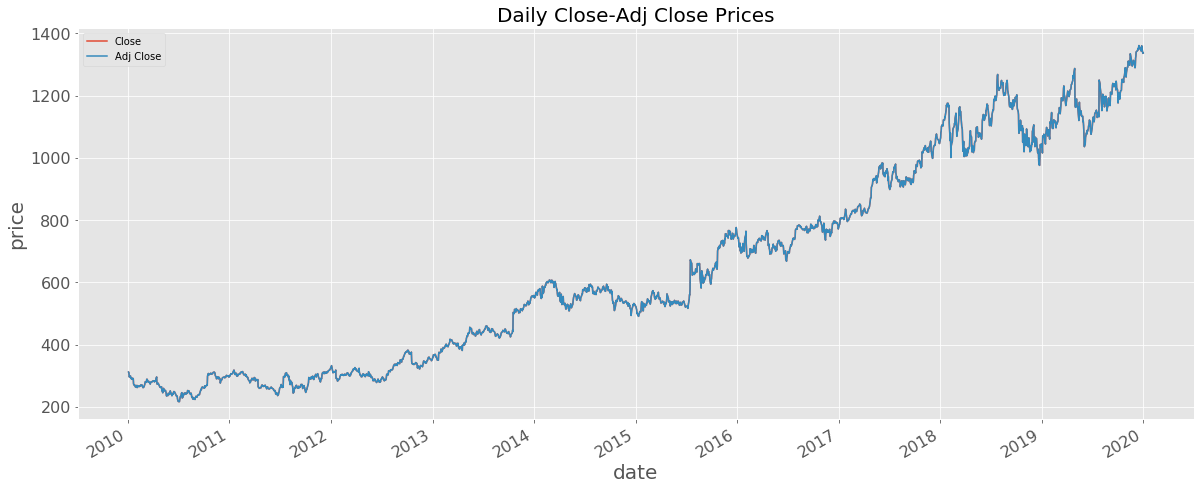

In [74]:
def plot_df(df, col, title=None):
    '''
    plot stock information
    input: 
        df - pandas dataframe containing historical stock information 
        col - array of strings: column names in df to plot
        title - title of plot.
    output: None
    '''
    fontsize=16
    if title == None:
        title = 'Daily '
        for c_name in col:
            title += c_name+'-'
        title = title[:-1]+' Prices'
        
    df[col].plot(figsize=(20,8), fontsize=fontsize);
    plt.title(title, fontsize=fontsize+4)
    plt.ylabel("price", fontsize=fontsize+4)
    plt.xlabel("date", fontsize=fontsize+4)
    plt.show()

plot_df(df_GOOG, ['Close','Adj Close'], )

## Create function to extract date features from stock data

In [75]:
#Convert Date column to datetime
def get_date_features(df):
    '''
    input: 
        df is dataframe of historical stock data where index is the date. 
    output:
        new_df with added features from the day.. 
    '''
    new_df = df[['Adj Close']]
    new_df = new_df.reset_index()
    new_df.columns = ['date','price']
    new_df.loc[:, 'date'] = pd.to_datetime(new_df['date'],format='%Y-%m-%d')
    new_df['year'] = new_df.date.dt.year
    new_df['month'] = new_df.date.dt.month
    new_df['day'] = new_df.date.dt.day
    
    return new_df

dd = get_date_features(df_GOOG)
print(dd.head(5))

        date       price  year  month  day
0 2010-01-04  312.204773  2010      1    4
1 2010-01-05  310.829926  2010      1    5
2 2010-01-06  302.994293  2010      1    6
3 2010-01-07  295.940735  2010      1    7
4 2010-01-08  299.885956  2010      1    8


## Create function to create linear model from historical data using date features

In [76]:
def get_lin_reg_model(df, target):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    
    X_train = df[['year', 'month', 'day']] #This is the set order for consistency
    y_train = df[target]
    
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)
    
    regr.fit(X_train, y_train)            # Train the model
    
    return regr

## Create function to get predicted stock prices from a pre trained model and test dates

In [77]:
# The order of the input dataframe is important
# This fnction will make sure the order is not lost
def get_pred(model, dates):
    return model.predict(dates[['year', 'month', 'day']])

In [78]:
model = get_preds_lin_reg(dd, 'price')
dd['preds'] = get_pred(model, dd)

print(dd.head(5))

        date       price  year  month  day       preds
0 2010-01-04  312.204773  2010      1    4  101.574423
1 2010-01-05  310.829926  2010      1    5  101.907267
2 2010-01-06  302.994293  2010      1    6  102.240111
3 2010-01-07  295.940735  2010      1    7  102.572955
4 2010-01-08  299.885956  2010      1    8  102.905799


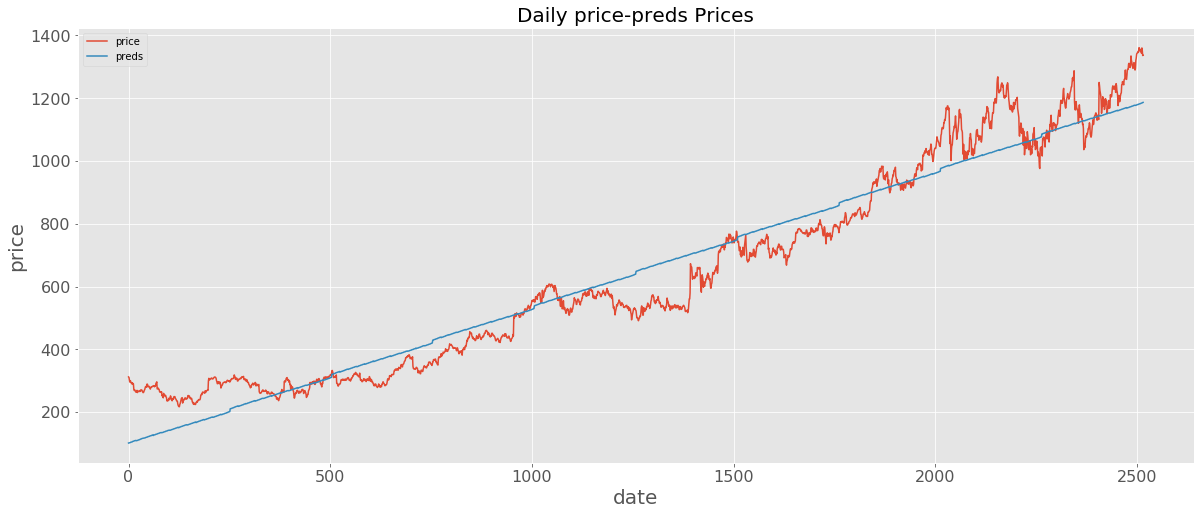

In [80]:
plot_df(dd, ['price', 'preds'])

In [ ]:
def evaluate_lin(df):
    model = get_preds_lin_reg(df, 'price')
    print(df.head(5))
    dd['preds'] = get_pred(model, df)
    plot_df(df, ['price', 'preds'])
    
evaluate_lin(dd)

## Create Function to split a dataframe into training-test

In [81]:
def split_train_test(df, cv_size = .2, test_size = .2):
    #Get sizes of each of the datasets
    num_cv = int(cv_size*len(df))
    num_test = int(test_size*len(df))
    num_train = len(df) - num_cv - num_test
    
    print("num_train = " + str(num_train))
    print("num_cv = " + str(num_cv))
    print("num_test = " + str(num_test))

    # Split into train, cv, and test
    train = df[:num_train]
    validation = df[num_train:num_train+num_cv]
    train_cv = df[:num_train+num_cv]
    test = df[num_train+num_cv:]
    
    print("train.shape = " + str(train.shape))
    print("cv.shape = " + str(validation.shape))
    print("train_cv.shape = " + str(train_cv.shape))
    print("test.shape = " + str(test.shape))
    
    return train, validation, train_cv, test

train, validation, train_cv, test = split_train_test(dd)

num_train = 1510
num_cv = 503
num_test = 503
train.shape = (1510, 6)
cv.shape = (503, 6)
train_cv.shape = (2013, 6)
test.shape = (503, 6)


num_train = 1510
num_cv = 503
num_test = 503
train.shape = (1510, 6)
cv.shape = (503, 6)
train_cv.shape = (2013, 6)
test.shape = (503, 6)
           date        price  year  month  day       preds
2013 2018-01-02  1065.000000  2018      1    2  889.355220
2014 2018-01-03  1082.479980  2018      1    3  889.606184
2015 2018-01-04  1086.400024  2018      1    4  889.857149
2016 2018-01-05  1102.229980  2018      1    5  890.108113
2017 2018-01-08  1106.939941  2018      1    8  890.861006

Training set RMS-error:  62.84600654678837
Test set RMS-error:  180.10741999688793

Training set R2-error:  0.9151949198896004
Test set R2-error:  -9.945724258784601


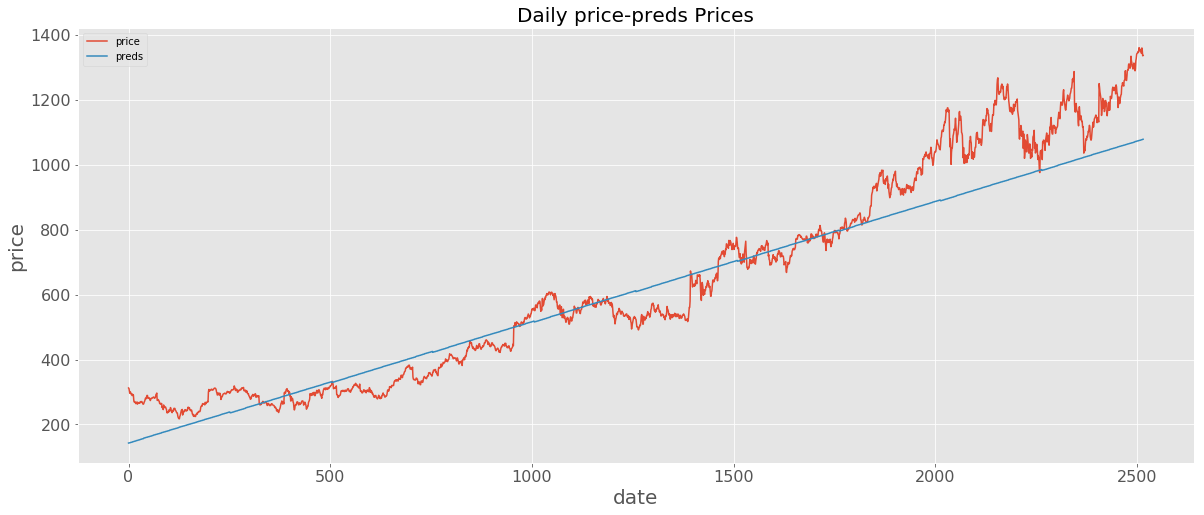

In [91]:
def evaluate_lin(df):
    train, validation, train_cv, test = split_train_test(df)
    model = get_preds_lin_reg(train_cv, 'price')
    train_cv['preds'] = get_pred(model, train_cv)
    test['preds'] = get_pred(model, test)
    print(test.head(5))
    print("\nTraining set RMS-error: ", math.sqrt(mean_squared_error(train_cv['preds'], train_cv['price'])))
    print("Test set RMS-error: ", math.sqrt(mean_squared_error(test['preds'], test['price'])))
    print("\nTraining set R2-error: ", r2_score(train_cv['preds'], train_cv['price']))
    print("Test set R2-error: ", r2_score(test['preds'], test['price']))
    
    
    plot_df(train_cv.append(test), ['price', 'preds'])
    
evaluate_lin(dd)

## K-nearest neighbors

XGBoost Best parameters:  {'n_neighbors': 5}
num_train = 1510
num_cv = 503
num_test = 503
train.shape = (1510, 6)
cv.shape = (503, 6)
train_cv.shape = (2013, 6)
test.shape = (503, 6)
           date        price  year  month  day        preds
2013 2018-01-02  1065.000000  2018      1    2  1020.752002
2014 2018-01-03  1082.479980  2018      1    3  1007.216003
2015 2018-01-04  1086.400024  2018      1    4  1025.743994
2016 2018-01-05  1102.229980  2018      1    5   968.920020
2017 2018-01-08  1106.939941  2018      1    8  1019.876001

Training set RMS-error:  32.80069254260203
Test set RMS-error:  51.73383205435312

Training set R2-error:  0.9782545206230289
Test set R2-error:  0.3477784780846237


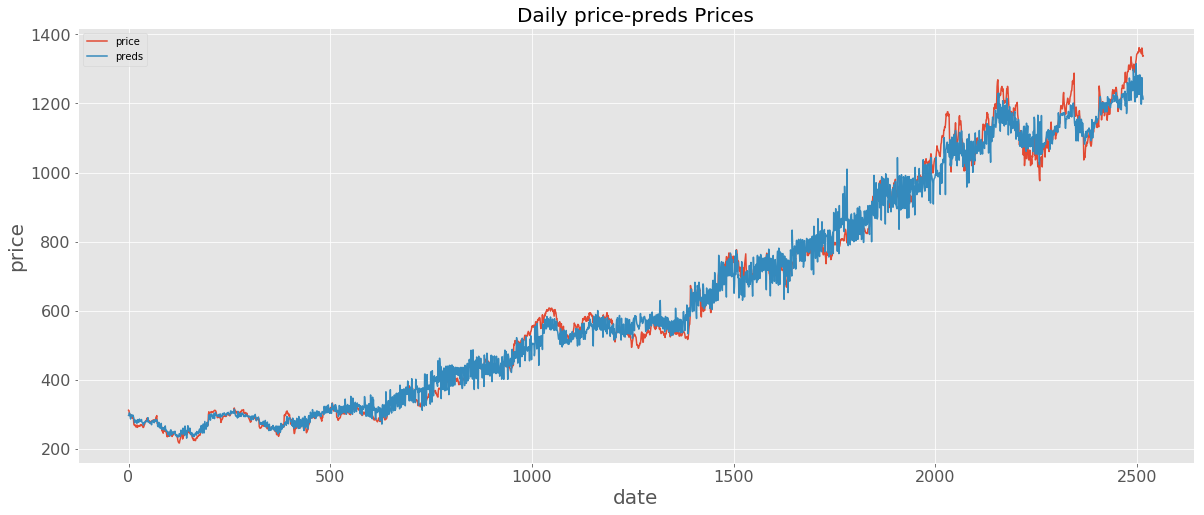

In [95]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

def get_knn_model(df, target):
    
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    x_train = df[['year', 'month', 'day']]
    y_train = df[target]
    
    #fit the model and make predictions
    model.fit(x_train, y_train)
    print('XGBoost Best parameters: ', model.best_params_)
    
    return model

def evaluate_knn(df):
    model = get_knn_model(df, 'price')
    train, validation, train_cv, test = split_train_test(df)
    train_cv['preds'] = get_pred(model, train_cv)
    test['preds'] = get_pred(model, test)
    print(test.head(5))
    print("\nTraining set RMS-error: ", math.sqrt(mean_squared_error(train_cv['preds'], train_cv['price'])))
    print("Test set RMS-error: ", math.sqrt(mean_squared_error(test['preds'], test['price'])))
    print("\nTraining set R2-error: ", r2_score(train_cv['preds'], train_cv['price']))
    print("Test set R2-error: ", r2_score(test['preds'], test['price']))
    
    plot_df(train_cv.append(test), ['price', 'preds'])
    
evaluate_knn(dd)

#### The model proved highly effective in predicting stock prices and was used for the prediction engine. 

In [100]:
d = pd.to_datetime("03/28/2020")
d 

Timestamp('2020-03-28 00:00:00')

In [102]:
"03/28/2020".split('/')

['03', '28', '2020']

In [113]:
def transform_date(date):
    new_df = pd.DataFrame({'date':pd.to_datetime(date)}, index=[1])
    new_df['year'] = new_df.date.dt.year
    new_df['month'] = new_df.date.dt.month
    new_df['day'] = new_df.date.dt.day
    
    return new_df
date = "03/28/2020"
t = transform_date(date)
t = get_pred(model, t)
t

array([1220.7280398])

In [120]:
# splitting user query with multiple stocks

sh = 'TSLA GOOG'

sh = sh.split()
for s in sh:
    d = get_stock_data(s)
    print(s)
    print(d.head(2))

TSLA
                  High         Low        Open       Close    Volume  \
Date                                                                   
2019-01-02  315.130005  298.799988  306.100006  310.119995  11658600   
2019-01-03  309.399994  297.380005  307.000000  300.359985   6965200   

             Adj Close  
Date                    
2019-01-02  310.119995  
2019-01-03  300.359985  
GOOG
                   High          Low         Open        Close   Volume  \
Date                                                                      
2019-01-02  1052.319946  1015.710022  1016.570007  1045.849976  1532600   
2019-01-03  1056.979980  1014.070007  1041.000000  1016.059998  1841100   

              Adj Close  
Date                     
2019-01-02  1045.849976  
2019-01-03  1016.059998  
